In [1]:
import os
import waymax
import json
import pickle
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory to the base directory 'gpudrive'
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

import gpudrive
from pygpudrive.env.config import SceneConfig
from pygpudrive.env.scene_selector import select_scenes

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'

### Configurations

In [3]:
DATA_DIR = 'data/processed' # Base data path
CKPT_DIR = 'data/checkpoints' # Base checkpoint path

SCENARIO_ID = '11671609ebfa3185' # Debugging scenario we use 
CKPT_PATH = 'integrations/models/vbd/weights/epoch=18.ckpt'

CMAP = 'bwr'

### Load scenarios

- We load an idential scenario both in waymax and gpudrive so that we can do a like for like comparison

In [4]:
# scenario in waymax
with open(f'{DATA_DIR}/waymax/waymax_scenario_{SCENARIO_ID}.pkl', 'rb') as f:
    waymax_scenario = pickle.load(f)
    
# same scenario in gpudrive
path_to_json_scene = f'data/processed/debug/tfrecord-{SCENARIO_ID}.json' 

# raw json scenario
with open(path_to_json_scene) as file:
    json_scenario = json.load(file)

2024-11-07 10:30:51.369302: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 10:30:51.376631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 10:30:51.378838: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 10:30:51.989095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
# json_scenario = select_scenes(SceneConfig("data/processed/debug", 1))

# # TODO: make sim to inspect scenario in gpudrive
# sim = gpudrive.SimManager( 
#     exec_mode=gpudrive.madrona.ExecMode.CPU, 
#     scenes=json_scenario,
#     gpu_id=0,
#     params=gpudrive.Parameters(),
# )

### Yaw comparison

> Main Q: Is `math.degrees(state.heading)` the same as `bbox_yaw`?

- Waymax:
    - Link: [in waymax](https://github.com/waymo-research/waymax/blob/720f9214a9bf79b3da7926497f0cd0468ca3e630/waymax/dataloader/womd_factories.py#L234C3-L234C15) they take the yaw directly from `bbox_yaw` [[tfexample data](https://waymo.com/open/data/motion/tfexample)]
- Raw json scenario
    - Processed from protobuf in `data_utils/process_waymo_files.py`
    
- GPUDrive (todo)
    - How is the json yaw info processed in GPUDrive? How can we align it with waymax?

In [6]:
waymax_yaw = waymax_scenario.log_trajectory.yaw

# Note that the waymax yaw is in radians from -pi to pi
waymax_yaw.shape, waymax_yaw.min(), waymax_yaw.max()

((32, 91), Array(-3.1415417, dtype=float32), Array(3.141505, dtype=float32))

In [7]:
json_yaws = []

for obj in json_scenario['objects']:
    if 'heading' in obj:
        json_yaws.append(obj['heading'])
json_yaws = np.array(json_yaws)
json_yaws.shape

(65, 91)

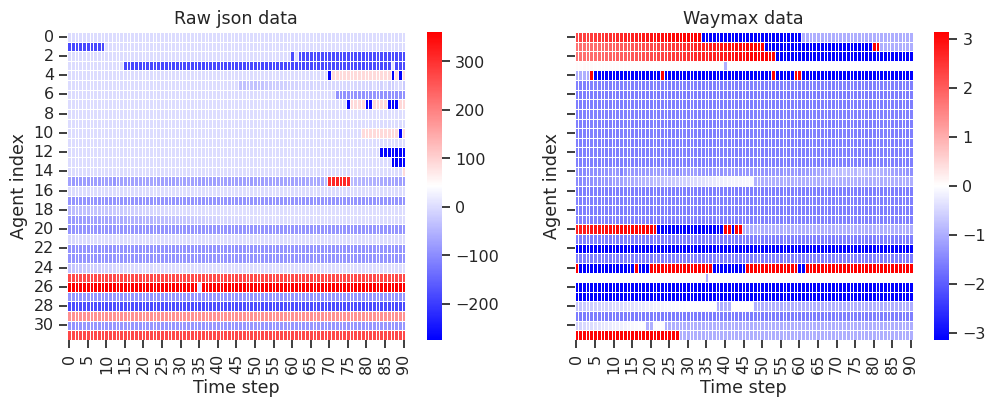

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

# Raw json data heatmap
sns.heatmap(json_yaws, cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[0])
axs[0].set_title('Raw json data')
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('Agent index')

# Waymax VBD data heatmap
sns.heatmap(waymax_scenario.log_trajectory.yaw, cmap=CMAP, linewidth=.5, cbar=True, annot=False, ax=axs[1])
axs[1].set_title('Waymax data')
axs[1].set_ylabel('Agent index')
axs[1].set_xlabel('Time step');

In [9]:
json_yaws.min(), json_yaws.max()

(-274.5298914238245, 360.9782297108419)

In [50]:
json_yaws.shape

(65, 91)

### Velocities comparison (`x` and `y`)

### Road points comparison

### 